# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

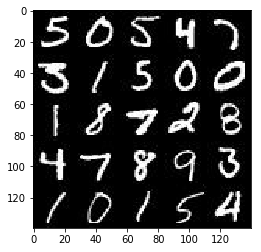

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

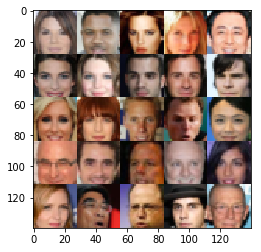

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_dim = [image_width, image_height, image_channels]
    
    inputs_real = tf.placeholder(tf.float32,(None,*real_dim),name = 'inputs_real')
    inputs_Z  = tf.placeholder(tf.float32,(None,z_dim),name = 'inputs_Z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return inputs_real,inputs_Z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        
        h1 = tf.layers.conv2d(images,128,5,strides = 2,padding='same')
        relu1 = tf.maximum(alpha*h1,h1)

        
        h2 = tf.layers.conv2d(images,512,5,strides = 2,padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        
        flat = tf.reshape(relu2, (-1, 7*7*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return logits,out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim,is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        h1 = tf.layers.dense(z, 7*7*512)
    
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake


    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
        
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
            
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

            
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.4175... Generator Loss: 0.4910
Epoch 0/2... Discriminator Loss: 1.3433... Generator Loss: 0.5573
Epoch 0/2... Discriminator Loss: 1.3636... Generator Loss: 0.5583
Epoch 0/2... Discriminator Loss: 1.4243... Generator Loss: 0.5390
Epoch 0/2... Discriminator Loss: 1.3992... Generator Loss: 0.5785
Epoch 0/2... Discriminator Loss: 1.3941... Generator Loss: 0.6065
Epoch 0/2... Discriminator Loss: 1.4001... Generator Loss: 0.6080
Epoch 0/2... Discriminator Loss: 1.3882... Generator Loss: 0.6265
Epoch 0/2... Discriminator Loss: 1.3804... Generator Loss: 0.6122


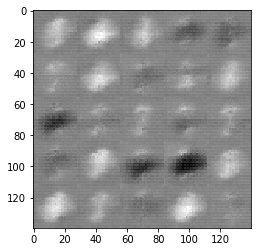

Epoch 0/2... Discriminator Loss: 1.3701... Generator Loss: 0.6100
Epoch 0/2... Discriminator Loss: 1.3559... Generator Loss: 0.6133
Epoch 0/2... Discriminator Loss: 1.3586... Generator Loss: 0.6189
Epoch 0/2... Discriminator Loss: 1.3349... Generator Loss: 0.6220
Epoch 0/2... Discriminator Loss: 1.3426... Generator Loss: 0.6220
Epoch 0/2... Discriminator Loss: 1.3337... Generator Loss: 0.6136
Epoch 0/2... Discriminator Loss: 1.3448... Generator Loss: 0.6157
Epoch 0/2... Discriminator Loss: 1.3501... Generator Loss: 0.6116
Epoch 0/2... Discriminator Loss: 1.3510... Generator Loss: 0.6012
Epoch 0/2... Discriminator Loss: 1.3476... Generator Loss: 0.5947


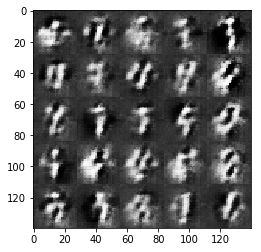

Epoch 0/2... Discriminator Loss: 1.3381... Generator Loss: 0.5956
Epoch 0/2... Discriminator Loss: 1.3277... Generator Loss: 0.5785
Epoch 0/2... Discriminator Loss: 1.3147... Generator Loss: 0.5936
Epoch 0/2... Discriminator Loss: 1.3279... Generator Loss: 0.5927
Epoch 0/2... Discriminator Loss: 1.3650... Generator Loss: 0.6043
Epoch 0/2... Discriminator Loss: 1.3663... Generator Loss: 0.6078
Epoch 0/2... Discriminator Loss: 1.3540... Generator Loss: 0.5936
Epoch 0/2... Discriminator Loss: 1.3570... Generator Loss: 0.6037
Epoch 0/2... Discriminator Loss: 1.3616... Generator Loss: 0.6005
Epoch 0/2... Discriminator Loss: 1.3483... Generator Loss: 0.6071


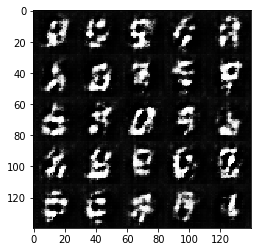

Epoch 0/2... Discriminator Loss: 1.3710... Generator Loss: 0.6100
Epoch 0/2... Discriminator Loss: 1.3575... Generator Loss: 0.5928
Epoch 0/2... Discriminator Loss: 1.3718... Generator Loss: 0.6034
Epoch 0/2... Discriminator Loss: 1.3607... Generator Loss: 0.6129
Epoch 0/2... Discriminator Loss: 1.3726... Generator Loss: 0.6140
Epoch 0/2... Discriminator Loss: 1.3627... Generator Loss: 0.6093
Epoch 0/2... Discriminator Loss: 1.3706... Generator Loss: 0.6192
Epoch 0/2... Discriminator Loss: 1.3752... Generator Loss: 0.6236
Epoch 0/2... Discriminator Loss: 1.3652... Generator Loss: 0.6015
Epoch 0/2... Discriminator Loss: 1.3725... Generator Loss: 0.6197


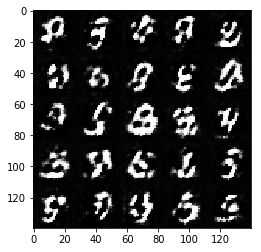

Epoch 0/2... Discriminator Loss: 1.3714... Generator Loss: 0.6197
Epoch 0/2... Discriminator Loss: 1.3751... Generator Loss: 0.6171
Epoch 0/2... Discriminator Loss: 1.3794... Generator Loss: 0.6208
Epoch 0/2... Discriminator Loss: 1.3737... Generator Loss: 0.6208
Epoch 0/2... Discriminator Loss: 1.3640... Generator Loss: 0.6104
Epoch 0/2... Discriminator Loss: 1.3661... Generator Loss: 0.6147
Epoch 0/2... Discriminator Loss: 1.3762... Generator Loss: 0.6196
Epoch 0/2... Discriminator Loss: 1.3720... Generator Loss: 0.6164
Epoch 0/2... Discriminator Loss: 1.3832... Generator Loss: 0.6293
Epoch 0/2... Discriminator Loss: 1.3707... Generator Loss: 0.6428


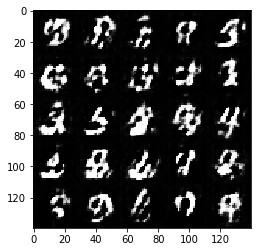

Epoch 0/2... Discriminator Loss: 1.3710... Generator Loss: 0.6272
Epoch 0/2... Discriminator Loss: 1.3680... Generator Loss: 0.6192
Epoch 0/2... Discriminator Loss: 1.3796... Generator Loss: 0.6312
Epoch 0/2... Discriminator Loss: 1.3651... Generator Loss: 0.6213
Epoch 0/2... Discriminator Loss: 1.3803... Generator Loss: 0.6463
Epoch 0/2... Discriminator Loss: 1.3684... Generator Loss: 0.6211
Epoch 0/2... Discriminator Loss: 1.3733... Generator Loss: 0.6182
Epoch 0/2... Discriminator Loss: 1.3727... Generator Loss: 0.6297
Epoch 0/2... Discriminator Loss: 1.3731... Generator Loss: 0.6166
Epoch 0/2... Discriminator Loss: 1.3787... Generator Loss: 0.6500


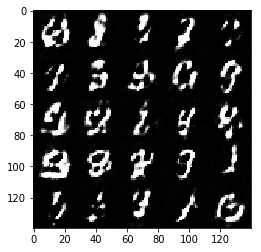

Epoch 0/2... Discriminator Loss: 1.3830... Generator Loss: 0.6293
Epoch 0/2... Discriminator Loss: 1.3726... Generator Loss: 0.6253
Epoch 0/2... Discriminator Loss: 1.3746... Generator Loss: 0.6224
Epoch 0/2... Discriminator Loss: 1.3717... Generator Loss: 0.6187
Epoch 0/2... Discriminator Loss: 1.3793... Generator Loss: 0.6162
Epoch 0/2... Discriminator Loss: 1.3722... Generator Loss: 0.6302
Epoch 0/2... Discriminator Loss: 1.3758... Generator Loss: 0.6297
Epoch 0/2... Discriminator Loss: 1.3738... Generator Loss: 0.6140
Epoch 0/2... Discriminator Loss: 1.3717... Generator Loss: 0.6217
Epoch 0/2... Discriminator Loss: 1.3686... Generator Loss: 0.6247


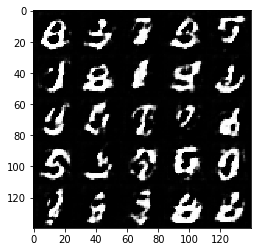

Epoch 0/2... Discriminator Loss: 1.3705... Generator Loss: 0.6304
Epoch 0/2... Discriminator Loss: 1.3641... Generator Loss: 0.6200
Epoch 0/2... Discriminator Loss: 1.3660... Generator Loss: 0.6093
Epoch 0/2... Discriminator Loss: 1.3729... Generator Loss: 0.6248
Epoch 0/2... Discriminator Loss: 1.3692... Generator Loss: 0.6191
Epoch 0/2... Discriminator Loss: 1.3669... Generator Loss: 0.6117
Epoch 0/2... Discriminator Loss: 1.3685... Generator Loss: 0.6312
Epoch 0/2... Discriminator Loss: 1.3743... Generator Loss: 0.6150
Epoch 0/2... Discriminator Loss: 1.3705... Generator Loss: 0.6229
Epoch 0/2... Discriminator Loss: 1.3703... Generator Loss: 0.6282


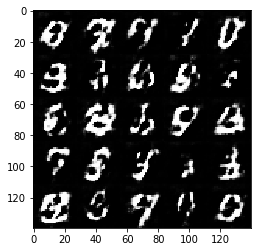

Epoch 0/2... Discriminator Loss: 1.3767... Generator Loss: 0.6200
Epoch 0/2... Discriminator Loss: 1.3660... Generator Loss: 0.6141
Epoch 0/2... Discriminator Loss: 1.3750... Generator Loss: 0.6412
Epoch 0/2... Discriminator Loss: 1.3728... Generator Loss: 0.5986
Epoch 0/2... Discriminator Loss: 1.3700... Generator Loss: 0.6232
Epoch 0/2... Discriminator Loss: 1.3799... Generator Loss: 0.6397
Epoch 0/2... Discriminator Loss: 1.3649... Generator Loss: 0.6383
Epoch 0/2... Discriminator Loss: 1.3771... Generator Loss: 0.6193
Epoch 0/2... Discriminator Loss: 1.3741... Generator Loss: 0.6263
Epoch 0/2... Discriminator Loss: 1.3798... Generator Loss: 0.6457


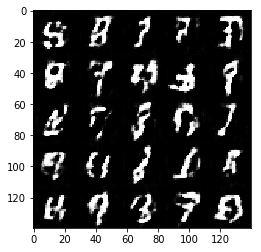

Epoch 0/2... Discriminator Loss: 1.3475... Generator Loss: 0.6048
Epoch 0/2... Discriminator Loss: 1.3765... Generator Loss: 0.6383
Epoch 0/2... Discriminator Loss: 1.3755... Generator Loss: 0.6225
Epoch 0/2... Discriminator Loss: 1.3668... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.6122


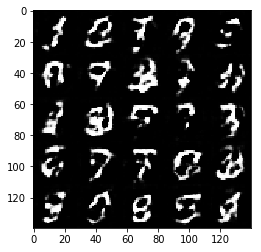

Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.6148
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.6212
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6287


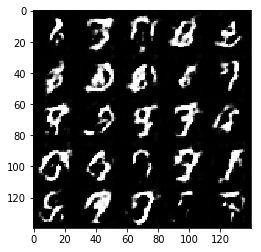

Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.6086
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.6309


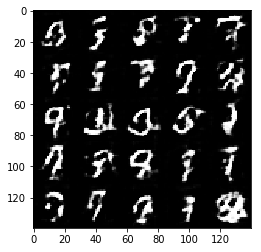

Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.6090
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6058
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.6194


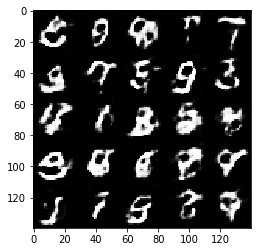

Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6149
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.6103
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.6072
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.6204
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.6055


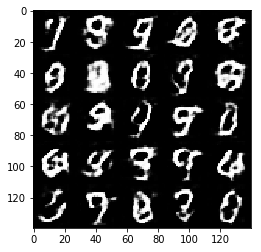

Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.6160


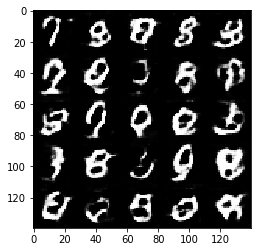

Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.5921


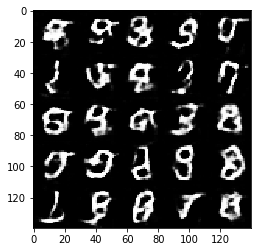

Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.5772


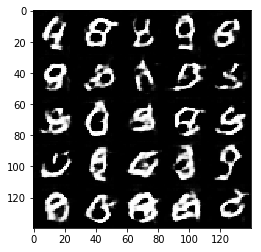

Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.6222
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.6069
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.6207


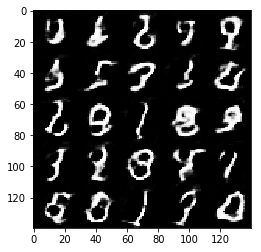

Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.6148


In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.5064... Generator Loss: 0.4520
Epoch 0/1... Discriminator Loss: 1.3349... Generator Loss: 0.5639
Epoch 0/1... Discriminator Loss: 1.3309... Generator Loss: 0.5879
Epoch 0/1... Discriminator Loss: 1.2406... Generator Loss: 0.6040
Epoch 0/1... Discriminator Loss: 1.3139... Generator Loss: 0.5748
Epoch 0/1... Discriminator Loss: 1.3738... Generator Loss: 0.6169
Epoch 0/1... Discriminator Loss: 1.3833... Generator Loss: 0.6473
Epoch 0/1... Discriminator Loss: 1.3863... Generator Loss: 0.6714
Epoch 0/1... Discriminator Loss: 1.3804... Generator Loss: 0.6663


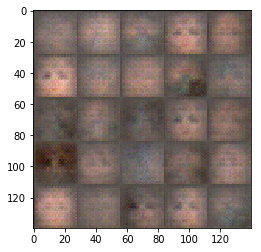

Epoch 0/1... Discriminator Loss: 1.3574... Generator Loss: 0.6469
Epoch 0/1... Discriminator Loss: 1.3781... Generator Loss: 0.6602
Epoch 0/1... Discriminator Loss: 1.3711... Generator Loss: 0.6585
Epoch 0/1... Discriminator Loss: 1.3759... Generator Loss: 0.6639
Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.6424
Epoch 0/1... Discriminator Loss: 1.3909... Generator Loss: 0.6479
Epoch 0/1... Discriminator Loss: 1.3866... Generator Loss: 0.6503
Epoch 0/1... Discriminator Loss: 1.4032... Generator Loss: 0.6412
Epoch 0/1... Discriminator Loss: 1.3863... Generator Loss: 0.6473
Epoch 0/1... Discriminator Loss: 1.3807... Generator Loss: 0.6617


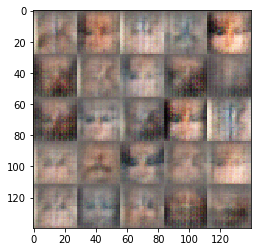

Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.6710
Epoch 0/1... Discriminator Loss: 1.3915... Generator Loss: 0.6612
Epoch 0/1... Discriminator Loss: 1.3919... Generator Loss: 0.6600
Epoch 0/1... Discriminator Loss: 1.3937... Generator Loss: 0.6643
Epoch 0/1... Discriminator Loss: 1.3957... Generator Loss: 0.6718
Epoch 0/1... Discriminator Loss: 1.3917... Generator Loss: 0.6602
Epoch 0/1... Discriminator Loss: 1.3902... Generator Loss: 0.6730
Epoch 0/1... Discriminator Loss: 1.3926... Generator Loss: 0.6668
Epoch 0/1... Discriminator Loss: 1.3839... Generator Loss: 0.6604
Epoch 0/1... Discriminator Loss: 1.3768... Generator Loss: 0.6592


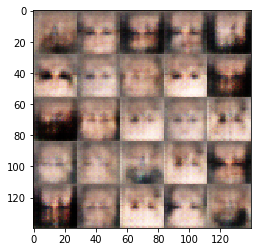

Epoch 0/1... Discriminator Loss: 1.3674... Generator Loss: 0.6424
Epoch 0/1... Discriminator Loss: 1.3874... Generator Loss: 0.6509
Epoch 0/1... Discriminator Loss: 1.4031... Generator Loss: 0.6333
Epoch 0/1... Discriminator Loss: 1.3848... Generator Loss: 0.6585
Epoch 0/1... Discriminator Loss: 1.3895... Generator Loss: 0.6659
Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 0.6815
Epoch 0/1... Discriminator Loss: 1.3887... Generator Loss: 0.6699
Epoch 0/1... Discriminator Loss: 1.3844... Generator Loss: 0.6824
Epoch 0/1... Discriminator Loss: 1.3924... Generator Loss: 0.6791
Epoch 0/1... Discriminator Loss: 1.3867... Generator Loss: 0.6831


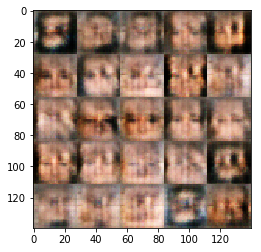

Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.6804
Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 0.6823
Epoch 0/1... Discriminator Loss: 1.3861... Generator Loss: 0.6835
Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.6521
Epoch 0/1... Discriminator Loss: 1.3908... Generator Loss: 0.6840
Epoch 0/1... Discriminator Loss: 1.3841... Generator Loss: 0.6825
Epoch 0/1... Discriminator Loss: 1.3912... Generator Loss: 0.6806
Epoch 0/1... Discriminator Loss: 1.3857... Generator Loss: 0.6872
Epoch 0/1... Discriminator Loss: 1.3865... Generator Loss: 0.6701
Epoch 0/1... Discriminator Loss: 1.3915... Generator Loss: 0.6851


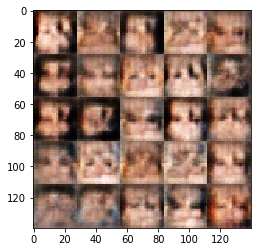

Epoch 0/1... Discriminator Loss: 1.3869... Generator Loss: 0.6907
Epoch 0/1... Discriminator Loss: 1.3866... Generator Loss: 0.6913
Epoch 0/1... Discriminator Loss: 1.3866... Generator Loss: 0.6914
Epoch 0/1... Discriminator Loss: 1.3871... Generator Loss: 0.6906
Epoch 0/1... Discriminator Loss: 1.3868... Generator Loss: 0.6904
Epoch 0/1... Discriminator Loss: 1.3888... Generator Loss: 0.6876
Epoch 0/1... Discriminator Loss: 1.3882... Generator Loss: 0.6886
Epoch 0/1... Discriminator Loss: 1.3887... Generator Loss: 0.6863
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.6901
Epoch 0/1... Discriminator Loss: 1.3876... Generator Loss: 0.6905


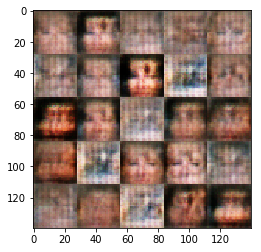

Epoch 0/1... Discriminator Loss: 1.3871... Generator Loss: 0.6912
Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.6908
Epoch 0/1... Discriminator Loss: 1.3875... Generator Loss: 0.6913


KeyboardInterrupt: 

In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.